# Autoregressive Gaussian models

A simple example for how to use autoregressive Gaussian ratio estimators to fit and sample from an exponential Gaussian process with heteroscedastic noise.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import torch
from torch import nn

import swyft
from swyft.utils.ns import SwyftSimpleSliceSampler
from swyft.lightning.estimators import LogRatioEstimator_Autoregressive, LogRatioEstimator_Gaussian, LogRatioEstimator_Autoregressive_Gaussian

import pylab as plt

#import pytorch_lightning as pl

torch.set_float32_matmul_precision('medium')
DEVICE = "cuda"

/Users/cweniger/opt/anaconda3/envs/native2/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/runner/miniforge3/conda-bld/pytorch-recipe_1664817727684/work/aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


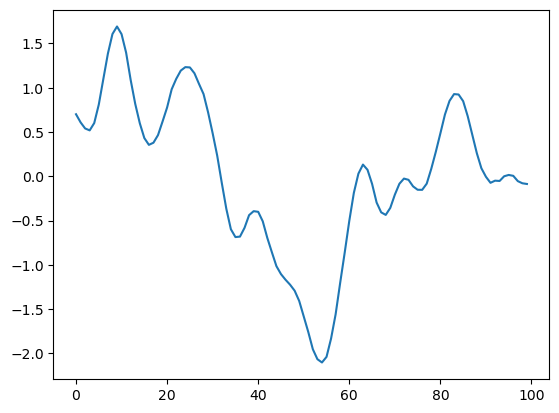

In [4]:
N = 100

l = torch.arange(N)
L1, L2 = torch.meshgrid(l, l)
T = torch.abs(L1 - L2)
Cov = torch.exp(-T**2/30)*0.2 + torch.exp(-T**2/200)*.2 + torch.exp(-T**2/0.001)*.0001

def sample_GP(N, gamma = 3):
    z = np.random.multivariate_normal(np.zeros(N), Cov.numpy())
    return z

z = sample_GP(N, gamma = 2.5)
plt.plot(z)

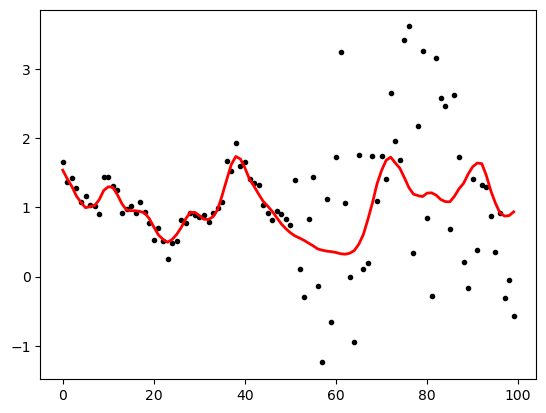

In [5]:
D = 100

class Sim(swyft.Simulator):
    def __init__(self, sigma = .1):
        super().__init__()
        self.transform_samples = swyft.to_numpy32
        self.sigma = np.ones(D)*sigma
        self.sigma[50:] *= 10
  
    def build(self, graph):
        z = graph.node("z", lambda: sample_GP(D, gamma = 2.5))
        y = graph.node("y", lambda z: np.exp(z), z)
        x = graph.node("x", lambda y: y + np.random.randn(D)*self.sigma, y)
        
sim = Sim()
for _ in range(1):
    s = sim.sample()
    plt.plot(s['x'], 'k.')
    plt.plot(s['y'], 'r', lw=2)

In [52]:
class Network(swyft.SwyftModule):
    def __init__(self, lr=1e-3, D = 100):
        super().__init__()

        self.optimizer_init = swyft.AdamOptimizerInit(lr=1e-3, lrs_factor=0.1, lrs_patience=3)
        self.num_params = D
        self.lre = LogRatioEstimator_Autoregressive_Gaussian(D, "mu", minstd = 1e-10)
        self.B = nn.LazyLinear(100)
        self.l = nn.Sequential(
            nn.LazyLinear(128),
            nn.ReLU(),
            nn.LazyLinear(128),
            nn.ReLU(),
            nn.LazyLinear(1)
        )

    def embed(self, x):
        f = self.l(x.unsqueeze(-1)).squeeze(-1)
#        f = torch.log(torch.where(x>1e-1, x, 1e-1))
        f = self.B(f)
        return f

    def forward(self, A, B):
        x = A["x"]
        f = self.embed(x)
        result = self.lre(f, A['z'], B['z'])
        return result

In [29]:
sim = Sim()
samples = sim.sample(1000)
dm = swyft.SwyftDataModule(samples, fractions = [0.9, 0.1, 0.0], batch_size = 64)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [53]:
net = Network(D=D)

In [54]:
net.lre._momentum = 0.01

In [55]:
trainer = swyft.SwyftTrainer(accelerator = "cpu", devices = 1, max_epochs = 50)
trainer.fit(net, dm)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type                                      | Params
-------------------------------------------------------------------
0 | lre  | LogRatioEstimator_Autoregressive_Gaussian | 20.0 K
1 | B    | LazyLinear                                | 0     
2 | l    | Sequential                                | 0     
-------------------------------------------------------------------
10.0 K    Trainable params
10.0 K    Non-trainable params
20.0 K    Total params
0.080     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


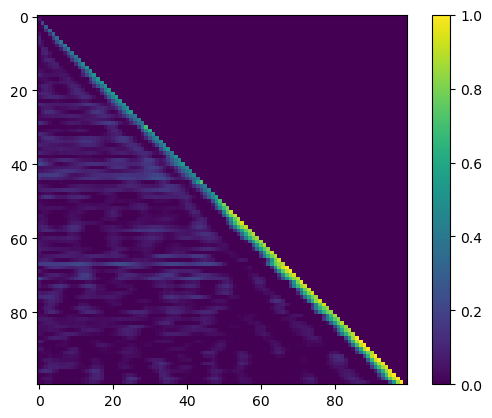

In [56]:
L = net.lre.L.detach().cpu().numpy()
plt.imshow(L, vmin = 0, vmax = 1)
plt.colorbar()

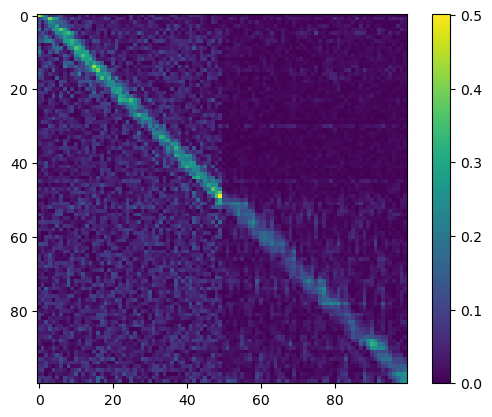

In [57]:
BW = net.B.weight.detach().cpu().numpy()
plt.imshow(np.abs(BW)[:, :], vmin = 0)
plt.colorbar()

967
tensor(1.7544, dtype=torch.float64)


/var/folders/xy/7m07k3417w76kc7zq5jpq3500000gn/T/ipykernel_13403/3205643100.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  f = net.embed(torch.tensor(x).to('cpu')).detach()


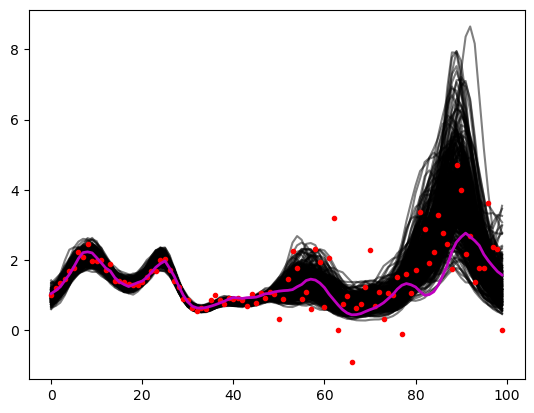

In [65]:
Cov = Cov.double().cpu()
i = np.random.randint(len(samples))
print(i)
x = torch.tensor(samples[i]['x'])
y = torch.tensor(samples[i]['y'])
net.cpu()
#f = net.l(torch.tensor(x).cpu().unsqueeze(-1)).squeeze(-1).detach()
f = net.embed(torch.tensor(x).to('cpu')).detach()
n = 300
draws = net.lre.get_post_samples(n, f, prior_cov = Cov, gamma = 1).cpu()

for i in range(n):
    plt.plot(np.exp(draws[i]), 'k', alpha = 0.5)

plt.plot(x, 'r.')
plt.plot(y, 'm', lw = 2)